# 🧠 Evasão de Clientes – Pipeline Completo (Telecom X)

Este notebook implementa **todo o fluxo** de ciência de dados para prever **evasão de clientes (churn)** e gerar insights acionáveis:

1) **Preparação dos dados**  
   - Remoção de colunas sem valor preditivo (ex.: IDs)  
   - Limpeza e tratamento de *missing values*  
   - Conversões de tipos (ex.: numérico)  
   - **Codificação** de variáveis categóricas (one-hot)  
   - **Balanceamento** de classes (SMOTE/oversampling/undersampling, conforme disponível)  
   - **Normalização/Padronização** quando necessário  

2) **Correlação & Seleção de Variáveis**  
   - Matriz de correlação (numéricas)  
   - Boxplots/dispersion para `tenure` (tempo de contrato) × *Churn* e `TotalCharges` × *Churn* (quando existirem)

3) **Modelagem Preditiva**  
   - `train_test_split` (70/30 – configurável)  
   - Dois ou mais modelos, com e sem normalização:  
     - **Regressão Logística** (requer normalização)  
     - **KNN** (requer normalização)  
     - **Random Forest** (não requer normalização)  
   - **Métricas**: Acurácia, Precisão, Recall, F1, Matriz de Confusão

4) **Interpretação**  
   - Coeficientes da Regressão Logística  
   - Importâncias de variáveis do Random Forest  
   - Observações sobre o KNN  
   - **Conclusão estratégica** com fatores-chave e sugestões de ações de retenção

> **Obs.**: O notebook **baixa os dados** diretamente do repositório original usado no seu projeto inicial. Caso esteja sem internet, rode novamente quando estiver conectado.


## 0. Imports & Configurações

In [5]:
# Imports principais
import os
import io
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelagem e métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Tentativa de importar técnicas de balanceamento; caso não existam, haverá fallback.
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    IMB_AVAILABLE = True
except Exception as e:
    print("Biblioteca imblearn não disponível. Será usado fallback simplificado de amostragem.", e)
    IMB_AVAILABLE = False

# Configs gerais
pd.set_option('display.max_columns', 200)
RANDOM_STATE = 42
TEST_SIZE = 0.30
SEED = RANDOM_STATE


## 1. Carregar os dados (mesma fonte do seu projeto inicial)

In [6]:
import requests

URL = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'

def load_data(url: str) -> pd.DataFrame:
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    # Se for lista de dicts simples, DataFrame direto. Senão, normalize.
    try:
        df = pd.DataFrame(data)
        # Caso a estrutura esteja aninhada, normalize
        if any(isinstance(v, (list, dict)) for v in df.iloc[0].values):
            df = pd.json_normalize(data)
    except Exception:
        df = pd.json_normalize(data)
    return df

df_raw = load_data(URL)
print("Formato (linhas, colunas):", df_raw.shape)
display(df_raw.head(3))

Formato (linhas, colunas): (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


## 2. Limpeza inicial e identificação da variável-alvo (Churn/Evasão)

- Remove colunas de **identificadores únicos** (ex.: `customerID`) e colunas com **unicidade muito alta** (quase todas diferentes).  
- Tenta identificar automaticamente a coluna **alvo** com base em nomes comuns (`Churn`, `Evasao`, etc.) ou em colunas binárias plausíveis.


In [7]:
# Funções auxiliares
def likely_id_columns(df: pd.DataFrame, uniqueness_threshold: float = 0.98):
    ids = []
    for col in df.columns:
        # Heurística: nomes comuns de ID e alta unicidade
        if col.lower() in {'customerid', 'id', 'clientid', 'clienteid', 'cpf', 'cnpj'}:
            ids.append(col)
        else:
            ratio = df[col].nunique(dropna=True) / max(1, len(df))
            if ratio >= uniqueness_threshold:
                ids.append(col)
    return ids

def infer_target_column(df: pd.DataFrame):
    # Tentativas por nome
    candidates_by_name = [c for c in df.columns if c.lower() in {
        'churn','evasao','evadido','evaded','exited','is_churn','cancelou','desistiu'
    }]
    if candidates_by_name:
        return candidates_by_name[0]
    # Caso não encontre por nome, buscar colunas com 2 classes plausíveis
    bin_cands = []
    for c in df.columns:
        vals = df[c].dropna().unique()
        if 2 <= len(vals) <= 3:  # binário clássico; tolera um valor nulo mapeado
            # valores mais comuns para churn
            valset = set([str(v).strip().lower() for v in vals])
            if valset.issubset({'yes','no','sim','não','nao','true','false','0','1'}):
                bin_cands.append(c)
    if bin_cands:
        return bin_cands[0]
    return None

# 1) Remover colunas-ID e com unicidade muito alta
id_cols = likely_id_columns(df_raw)
df = df_raw.drop(columns=id_cols, errors='ignore')
print("Removidas colunas de ID/alta unicidade:", id_cols)

# 2) Inferir coluna alvo
target = infer_target_column(df)
print("Coluna alvo inferida:", target)

if target is None:
    # Se não encontrar, tentar 'Churn' clássico por segurança (dataset Telco usual)
    if 'Churn' in df.columns:
        target = 'Churn'
    elif 'churn' in df.columns:
        target = 'churn'
    else:
        raise ValueError("Não foi possível identificar automaticamente a coluna alvo (Churn/Evasão). Defina manualmente.")

# Padronizar valores alvo para 0/1
df[target] = df[target].astype(str).str.strip().str.lower().replace({
    'yes': 1, 'sim': 1, 'true': 1, '1': 1,
    'no': 0, 'nao': 0, 'não': 0, 'false': 0, '0': 0
})

# Padronizar valores alvo para 0/1
df[target] = df[target].astype(str).str.strip().str.lower().replace({
    'yes': 1, 'sim': 1, 'true': 1, '1': 1,
    'no': 0, 'nao': 0, 'não': 0, 'false': 0, '0': 0
})

# Substituir valores não mapeados ou vazios por NaN
df[target] = pd.to_numeric(df[target], errors='coerce')

# Opcional: decidir o que fazer com NaN — geralmente, removemos
df = df.dropna(subset=[target])

# Garantir tipo int
df[target] = df[target].astype(int)

display(df[[target]].head())
print("Valores únicos na coluna alvo:", df[target].unique())


df[target] = df[target].astype(int)

display(df[[target]].head())

Removidas colunas de ID/alta unicidade: ['customerID']
Coluna alvo inferida: Churn


,Churn
0,0
1,0
2,1
3,1
4,1


Valores únicos na coluna alvo: [0 1]


,Churn
0,0
1,0
2,1
3,1
4,1


## 3. Tratamento de tipos, *missing values* e conversões

- Conversão de colunas numéricas mal tipadas (ex.: `"TotalCharges"` como texto).  
- Preenchimento de *missings* (média/mediana para numéricas; categoria `"Missing"` para categóricas).


In [8]:
# Corrigir tipos numéricos comuns no dataset de churn de telecom
for col in df.columns:
    if df[col].dtype == object:
        # Tentar converter para numérico se fizer sentido (sem sobrescrever target binário já tratado)
        if col != target:
            try:
                df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')
            except Exception:
                pass

# Separar tipos após tentativa de conversão
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if target in numeric_cols:
    # target é numérico binário; manter no conjunto, mas tirar de 'features numéricas'
    numeric_cols = [c for c in numeric_cols if c != target]
cat_cols = [c for c in df.columns if c not in numeric_cols + [target]]

print("Numéricas:", numeric_cols[:15], "...")
print("Categóricas:", cat_cols[:15], "...")

# Missing values
for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna('Missing')


Numéricas: ['customer.SeniorCitizen', 'customer.tenure', 'account.Charges.Monthly'] ...
Categóricas: ['customer.gender', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod'] ...


/tmp/ipython-input-875214552.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='ignore')


## 4. Proporção de evasão (balanceamento das classes)

Distribuição da classe (0 = permaneceu, 1 = evadiu):


,count
Churn,
0,5174
1,1869


Proporção classe 0: 0.735 | classe 1: 0.265


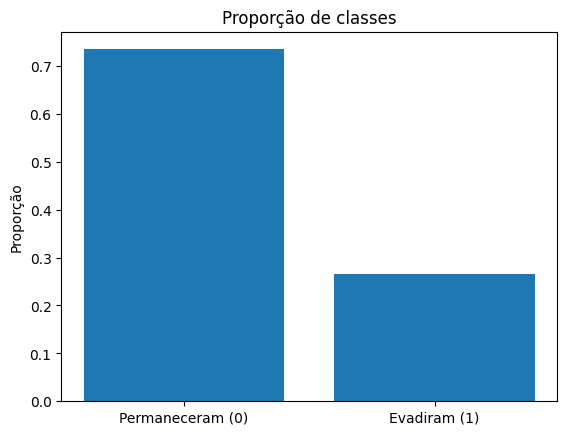

Dados desbalanceados? True


In [9]:
# Distribuição da classe
class_counts = df[target].value_counts().sort_index()
total = class_counts.sum()
prop_0 = class_counts.get(0, 0) / total if total else 0
prop_1 = class_counts.get(1, 0) / total if total else 0

print("Distribuição da classe (0 = permaneceu, 1 = evadiu):")
display(class_counts)
print(f"Proporção classe 0: {prop_0:.3f} | classe 1: {prop_1:.3f}")

# Visual simples
plt.figure()
plt.bar(['Permaneceram (0)','Evadiram (1)'], [prop_0, prop_1])
plt.title('Proporção de classes')
plt.ylabel('Proporção')
plt.show()

IMBALANCED = min(prop_0, prop_1) < 0.35  # regra simples
print("Dados desbalanceados?", IMBALANCED)

## 5. One-Hot Encoding (variáveis categóricas)

In [10]:
# One-hot nas categóricas (drop_first para evitar multicolinearidade)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(columns=[target])
y = df_encoded[target]

print("Shape X, y:", X.shape, y.shape)

Shape X, y: (7043, 6559) (7043,)


## 6. Matriz de correlação (numéricas) e relações com *Churn*

Observa correlações das variáveis numéricas com a evasão e visualiza relações de:
- **Tenure × Churn** (tempo de contrato)
- **TotalCharges × Churn** (total gasto)


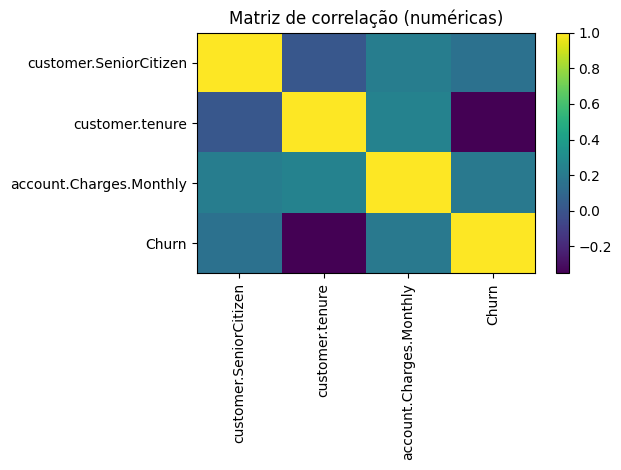

In [11]:
# Matriz de correlação só com numéricas + target
num_for_corr = df[numeric_cols + [target]].copy() if numeric_cols else df[[target]].copy()
corr = num_for_corr.corr(numeric_only=True)

plt.figure()
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.title('Matriz de correlação (numéricas)')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

# Boxplots/Scatter para Tenure e TotalCharges, se existirem
cols_possible_tenure = [c for c in df.columns if c.lower() in {'tenure','meses_como_cliente','tempo_contrato'}]
cols_possible_total = [c for c in df.columns if c.lower() in {'totalcharges','total_charge','total_gasto','gasto_total'}]

if cols_possible_tenure:
    col_ten = cols_possible_tenure[0]
    plt.figure()
    # Boxplot separado por churn
    data0 = df[df[target]==0][col_ten].dropna()
    data1 = df[df[target]==1][col_ten].dropna()
    plt.boxplot([data0, data1], labels=['0 - Permaneceu','1 - Evadiu'])
    plt.title(f'Boxplot: {col_ten} × {target}')
    plt.ylabel(col_ten)
    plt.show()

if cols_possible_total:
    col_tot = cols_possible_total[0]
    plt.figure()
    plt.scatter(df[col_tot], df[target], s=8, alpha=0.5)
    plt.title(f'Dispersão: {col_tot} × {target}')
    plt.xlabel(col_tot)
    plt.ylabel(target)
    plt.show()

## 7. Split Treino/Teste e Balanceamento

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape)

def balance_data(X, y):
    if not IMBALANCED:
        return X, y, 'Sem balanceamento (classes equilibradas)'
    if IMB_AVAILABLE:
        # Preferir SMOTE quando há features contínuas suficientes
        try:
            sm = SMOTE(random_state=RANDOM_STATE)
            X_res, y_res = sm.fit_resample(X, y)
            return X_res, y_res, 'SMOTE (oversampling sintético)'
        except Exception as e:
            # Fallback para RandomOverSampler
            try:
                ros = RandomOverSampler(random_state=RANDOM_STATE)
                X_res, y_res = ros.fit_resample(X, y)
                return X_res, y_res, 'RandomOverSampler (oversampling)'
            except Exception:
                pass
        # Fallback final: undersampling simples
        try:
            rus = RandomUnderSampler(random_state=RANDOM_STATE)
            X_res, y_res = rus.fit_resample(X, y)
            return X_res, y_res, 'RandomUnderSampler (undersampling)'
        except Exception as e:
            print("Falha ao balancear com imblearn. Seguindo sem balanceamento.", e)
            return X, y, 'Sem balanceamento (falha imblearn)'
    else:
        # Fallback sem imblearn: undersampling manual simples
        counts = y.value_counts()
        min_class = counts.idxmin()
        max_class = counts.idxmax()
        n = counts[min_class]
        idx_min = y[y==min_class].index
        idx_max = y[y==max_class].sample(n=n, random_state=RANDOM_STATE).index
        idx_bal = idx_min.union(idx_max)
        return X.loc[idx_bal], y.loc[idx_bal], 'Undersampling simples (fallback)'

X_train_bal, y_train_bal, bal_strategy = balance_data(X_train, y_train)
print("Estrategia de balanceamento:", bal_strategy)
print("Distribuição pós-balanceamento:")
display(y_train_bal.value_counts())

Shapes -> X_train: (4930, 6559) | X_test: (2113, 6559)
Estrategia de balanceamento: SMOTE (oversampling sintético)
Distribuição pós-balanceamento:


,count
Churn,
0,3622
1,3622


## 8. Normalização/Padronização (para modelos baseados em distância)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)  # importante: só transforma com o fit do treino

## 9. Treinamento de Múltiplos Modelos

In [14]:
results = {}

# 9.1 Regressão Logística (com padronização)
logreg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE, n_jobs=None)
logreg.fit(X_train_scaled, y_train_bal)
y_pred_lr = logreg.predict(scaler.transform(X_test))

results['LogisticRegression'] = {
    'y_pred': y_pred_lr,
    'model': logreg,
    'uses_scaler': True
}

# 9.2 KNN (com padronização)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train_bal)
y_pred_knn = knn.predict(scaler.transform(X_test))

results['KNN'] = {
    'y_pred': y_pred_knn,
    'model': knn,
    'uses_scaler': True
}

# 9.3 Random Forest (sem padronização)
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test)

results['RandomForest'] = {
    'y_pred': y_pred_rf,
    'model': rf,
    'uses_scaler': False
}

print("Modelos treinados:", list(results.keys()))

Modelos treinados: ['LogisticRegression', 'KNN', 'RandomForest']


## 10. Avaliação de Desempenho


### LogisticRegression
Acurácia: 0.7326 | Precisão: 0.4975 | Recall: 0.6970 | F1: 0.5805

Matriz de Confusão:
 [[1157  395]
 [ 170  391]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.80      1552
           1       0.50      0.70      0.58       561

    accuracy                           0.73      2113
   macro avg       0.68      0.72      0.69      2113
weighted avg       0.77      0.73      0.74      2113


### KNN
Acurácia: 0.7331 | Precisão: 0.4727 | Recall: 0.0463 | F1: 0.0844

Matriz de Confusão:
 [[1523   29]
 [ 535   26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.98      0.84      1552
           1       0.47      0.05      0.08       561

    accuracy                           0.73      2113
   macro avg       0.61      0.51      0.46      2113
weighted avg       0.67      0.73      0.64      2113


### RandomForest
Acurácia: 0.785

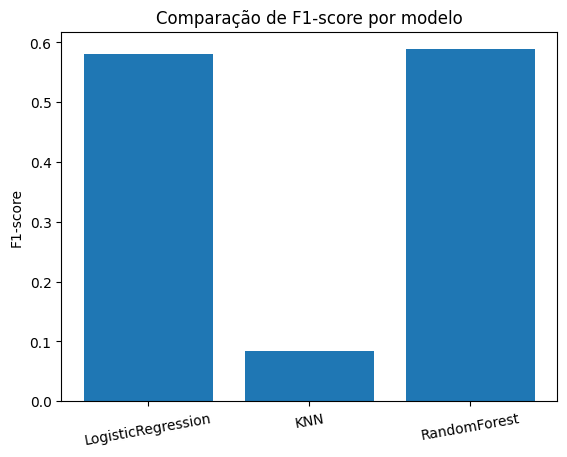

In [15]:
def evaluate(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n### {name}")
    print(f"Acurácia: {acc:.4f} | Precisão: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("\nMatriz de Confusão:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm}

metrics = {}
for name, info in results.items():
    metrics[name] = evaluate(name, y_test, info['y_pred'])

# Barplot simples das métricas F1 por modelo
plt.figure()
plt.bar(list(metrics.keys()), [metrics[m]['f1'] for m in metrics])
plt.title('Comparação de F1-score por modelo')
plt.ylabel('F1-score')
plt.xticks(rotation=10)
plt.show()

## 11. Interpretação dos Modelos

,feature,coef,abs_coef
27,account.PaymentMethod_Electronic check,1.111232,1.111232
24,account.Contract_Two year,-0.951362,0.951362
14,internet.OnlineBackup_Yes,-0.849990,0.849990
1,customer.tenure,-0.771896,0.771896
23,account.Contract_One year,-0.752779,0.752779
22,internet.StreamingMovies_Yes,0.748427,0.748427
28,account.PaymentMethod_Mailed check,0.606298,0.606298
25,account.PaperlessBilling_Yes,0.587856,0.587856
9,internet.InternetService_Fiber optic,0.533649,0.533649
26,account.PaymentMethod_Credit card (automatic),0.517063,0.517063


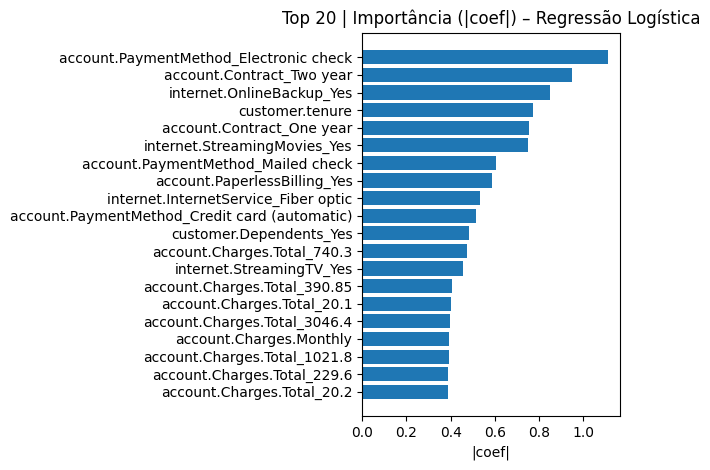

,feature,importance
1,customer.tenure,0.121222
2,account.Charges.Monthly,0.077717
27,account.PaymentMethod_Electronic check,0.054358
24,account.Contract_Two year,0.037412
25,account.PaperlessBilling_Yes,0.034473
9,internet.InternetService_Fiber optic,0.030782
23,account.Contract_One year,0.019963
18,internet.TechSupport_Yes,0.016269
3,customer.gender_Male,0.015359
12,internet.OnlineSecurity_Yes,0.014148


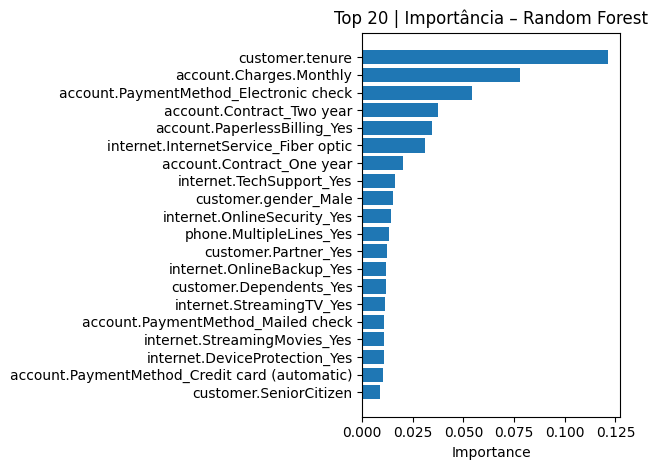


KNN não fornece coeficientes/importance nativamente. 
A interpretação depende de como as **distâncias** no espaço transformado (padronizado) separam as classes. 
Em geral, features mais relevantes são aquelas que melhor discriminam vizinhos de classes distintas.


In [16]:
# 11.1 Coeficientes da Regressão Logística
feature_names = X.columns.tolist()
if 'LogisticRegression' in results:
    lr = results['LogisticRegression']['model']
    coefs = lr.coef_.flatten()
    coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    coef_df['abs_coef'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=False).head(20)
    display(coef_df)

    # Plot top coef (absoluto)
    plt.figure()
    plt.barh(coef_df['feature'][::-1], coef_df['abs_coef'][::-1])
    plt.title('Top 20 | Importância (|coef|) – Regressão Logística')
    plt.xlabel('|coef|')
    plt.tight_layout()
    plt.show()

# 11.2 Importância de variáveis no Random Forest
if 'RandomForest' in results:
    rf = results['RandomForest']['model']
    importances = rf.feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    imp_df = imp_df.sort_values('importance', ascending=False).head(20)
    display(imp_df)

    plt.figure()
    plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
    plt.title('Top 20 | Importância – Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# 11.3 Observações sobre KNN
print("""\nKNN não fornece coeficientes/importance nativamente.
A interpretação depende de como as **distâncias** no espaço transformado (padronizado) separam as classes.
Em geral, features mais relevantes são aquelas que melhor discriminam vizinhos de classes distintas.""")

## 12. Conclusão Estratégica

Abaixo, o notebook gera um resumo textual automático com:
- Modelo de **melhor desempenho** (com base no F1).  
- **Principais variáveis** (com base nos coeficientes da LogReg e importâncias do RF).  
- **Sugestões de ações** de retenção alinhadas aos fatores de risco encontrados.


In [17]:
# Escolher melhor modelo por F1
best_model = max(metrics.items(), key=lambda kv: kv[1]['f1'])[0]
best_f1 = metrics[best_model]['f1']

# Top variáveis por LogReg e RF (se existirem)
top_lr = []
try:
    top_lr = (pd.DataFrame({'feature': X.columns, 'coef': results['LogisticRegression']['model'].coef_.flatten()})
              .assign(abs_coef=lambda d: d['coef'].abs())
              .sort_values('abs_coef', ascending=False)['feature'].head(10).tolist())
except Exception:
    pass

top_rf = []
try:
    top_rf = (pd.DataFrame({'feature': X.columns, 'importance': results['RandomForest']['model'].feature_importances_})
              .sort_values('importance', ascending=False)['feature'].head(10).tolist())
except Exception:
    pass

factors = list(dict.fromkeys(top_lr + top_rf))[:10]  # unir mantendo ordem e limitar

print("==== CONCLUSÃO ESTRATÉGICA ====")
print(f"Melhor modelo (por F1): {best_model} | F1={best_f1:.3f}\n")

if factors:
    print("Principais fatores associados à evasão (indicativos):")
    for i, f in enumerate(factors, 1):
        print(f" {i}. {f}")
else:
    print("Não foi possível extrair fatores principais.")

print("""\nSugestões de retenção (exemplos alinhados aos fatores):
- Oferecer **planos com fidelização ou descontos** para clientes de baixa permanência (tenure baixo).
- Criar alertas para **aumentos atípicos no total gasto** que possam frustrar o cliente (revisão de faturas, bônus).
- Priorizar **atendimento proativo** para segmentos/planos com maior propensão à evasão.
- Ofertar **upgrades/downgrades** personalizados para adequar preço ao uso.
- Acompanhar clientes em **períodos críticos** (primeiros meses) com onboarding e check-ins.
""")

==== CONCLUSÃO ESTRATÉGICA ====
Melhor modelo (por F1): RandomForest | F1=0.589

Principais fatores associados à evasão (indicativos):
 1. account.PaymentMethod_Electronic check
 2. account.Contract_Two year
 3. internet.OnlineBackup_Yes
 4. customer.tenure
 5. account.Contract_One year
 6. internet.StreamingMovies_Yes
 7. account.PaymentMethod_Mailed check
 8. account.PaperlessBilling_Yes
 9. internet.InternetService_Fiber optic
 10. account.PaymentMethod_Credit card (automatic)

Sugestões de retenção (exemplos alinhados aos fatores):
- Oferecer **planos com fidelização ou descontos** para clientes de baixa permanência (tenure baixo).
- Criar alertas para **aumentos atípicos no total gasto** que possam frustrar o cliente (revisão de faturas, bônus).
- Priorizar **atendimento proativo** para segmentos/planos com maior propensão à evasão.
- Ofertar **upgrades/downgrades** personalizados para adequar preço ao uso.
- Acompanhar clientes em **períodos críticos** (primeiros meses) com onboa

---

### Reprodutibilidade
- Fixamos `random_state=42` onde aplicável.
- `train_test_split=70/30` (ajuste `TEST_SIZE` se desejar 0.2 para 80/20).
- Ajuste hiperparâmetros dos modelos para buscar desempenho ainda melhor (ex.: `GridSearchCV`).

### Observação
Caso alguma coluna tenha nome diferente do padrão (ex.: `tenure`, `TotalCharges`, `customerID`), as etapas são **robustas** e procuram automaticamente colunas equivalentes quando possível.
